In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
#carregar os dados para um dataframe
df = pd.read_csv('/content/ASTR-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adjclose,Volume
0,2023-01-01,0.038462,0.039739,0.038280,0.039411,0.039411,2444991
1,2023-01-02,0.039373,0.040338,0.039012,0.039299,0.039299,2977728
2,2023-01-03,0.039294,0.039476,0.038836,0.039003,0.039003,2283884
3,2023-01-04,0.039000,0.040326,0.038932,0.039358,0.039358,3154344
4,2023-01-05,0.039350,0.039693,0.038635,0.038856,0.038856,2094343


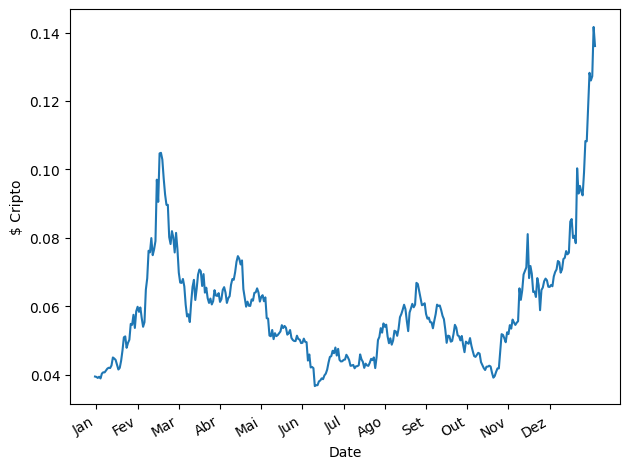

In [ ]:
#Plota o grafico utilizando os dados da coluna Adjclose
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Adjclose'])
ax.set_xlabel('Date')
ax.set_ylabel('$ Cripto')

plt.xticks(np.arange(1, 360, 30), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])

fig.autofmt_xdate()
plt.tight_layout()


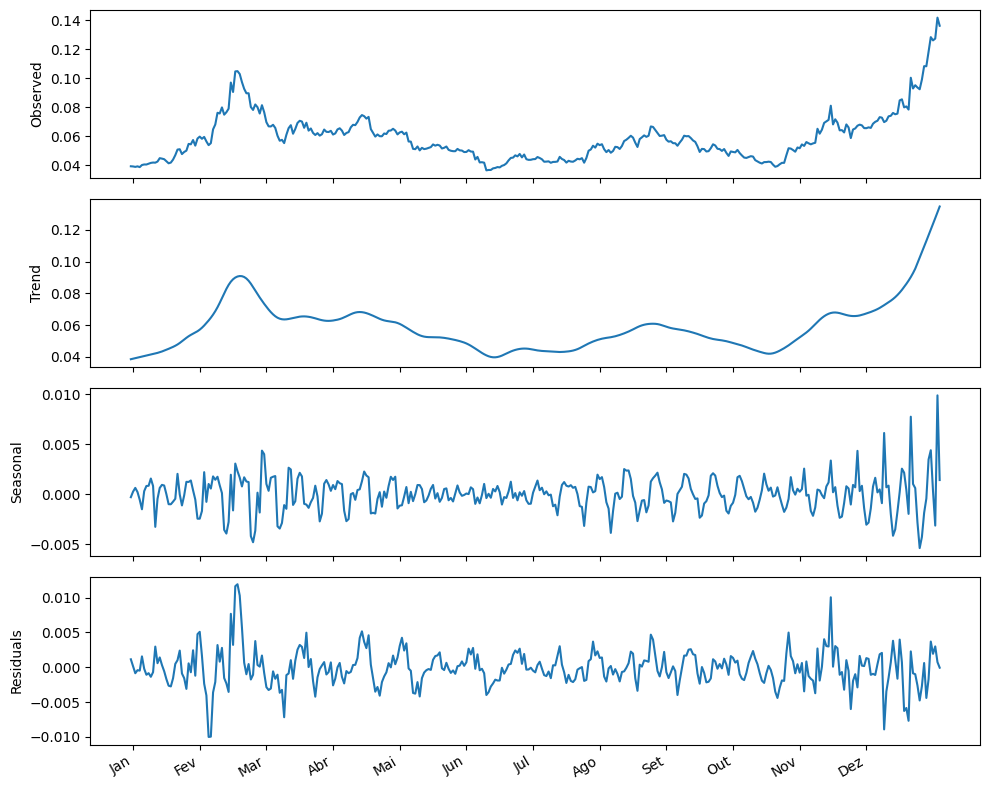

In [ ]:
#decompõe a serie em dados observados, sazonalidade, tendência e residuo e plota o grafico.
decomposition = STL(df['Adjclose'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(1, 360, 30), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])

fig.autofmt_xdate()
plt.tight_layout()


In [ ]:
#teste de estacionaridade. O pvalue é maior que 0,05 e por tanto, não podemos rejeitar a hipotes nula.
ad_fuller_result = adfuller(df['Adjclose'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.7831296119870331
p-value: 0.9913589096971421


In [ ]:
#podemos rejeitar a hipotese nula e a serie é estacionaria
df_diff = np.diff(df['Adjclose'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -12.575190978961103
p-value: 1.9644502098516014e-23


In [ ]:
#podemos rejeitar a hipotese nula e a serie é estacionaria
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -22.33857246062261
p-value: 0.0


In [ ]:
#podemos rejeitar a hipotese nula e a serie é estacionaria
df_diff2 = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.05381624420724
p-value: 1.389955052900634e-17


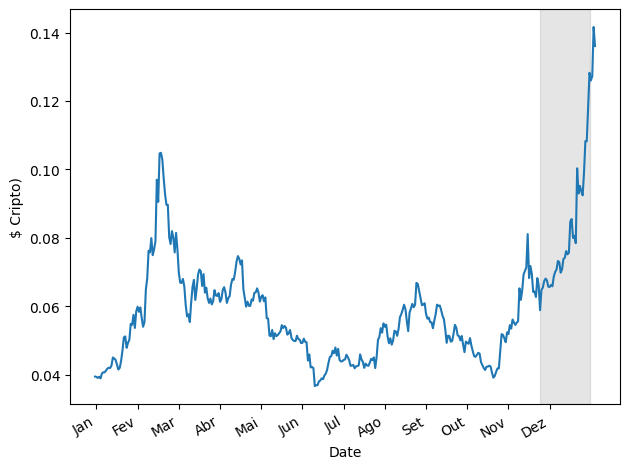

In [ ]:
#plota o grafico e marca os 10% do conjunto de teste com a cor azul
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Adjclose'])
ax.set_xlabel('Date')
ax.set_ylabel('$ Cripto)')
ax.axvspan(324, 360, color='#808080', alpha=0.2)

plt.xticks(np.arange(1, 360, 30), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [ ]:
#utiliza o modelo Arima para modelar os dados

ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Adjclose'][:-36]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(1, 2, 0, 0)",-2864.214239
1,"(3, 2, 0, 0)",-2859.936266
2,"(0, 5, 0, 0)",-2859.352510
3,"(4, 9, 0, 0)",-2859.184804
4,"(4, 2, 0, 0)",-2858.750180
...,...,...
164,"(10, 4, 0, 0)",-2756.998386
165,"(11, 10, 0, 0)",-2739.334668
166,"(0, 0, 0, 0)",-2615.942234
167,"(8, 8, 0, 0)",-2583.973134


In [154]:
#utiliza o modelo Sarima para modelar os dados
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Adjclose'][:-36]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 0, 1)",-2741.109025
1,"(2, 1, 0, 1)",-2738.692752
2,"(1, 1, 0, 1)",-2738.045298
3,"(0, 1, 0, 1)",-2737.313798
4,"(1, 2, 0, 1)",-2736.890899
...,...,...
251,"(1, 0, 0, 0)",-2570.199044
252,"(0, 0, 0, 0)",-2569.528602
253,"(1, 1, 0, 0)",-2569.379832
254,"(0, 1, 0, 0)",-2569.209176


In [155]:
#ajusta o modelo sarimax aos dados de treinamento e imprimindo um resumo do modelo ajustado
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:               Adjclose   No. Observations:                  329
Model:              SARIMAX(11, 2, 3)   Log Likelihood                1424.924
Date:                Wed, 28 Feb 2024   AIC                          -2819.847
Time:                        06:28:54   BIC                          -2762.998
Sample:                             0   HQIC                         -2797.163
                                - 329                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4417      0.594     -0.744      0.457      -1.606       0.722
ar.L2         -0.0575      0.225     -0.255      0.798      -0.499       0.384
ar.L3          0.0921      0.116      0.791      0.4

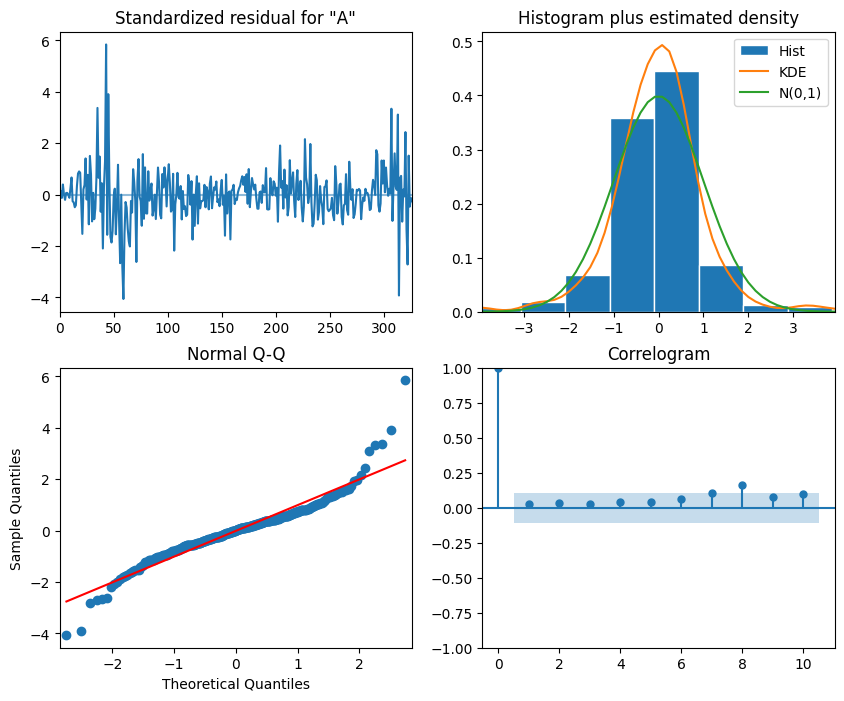

In [156]:
#gerando os gráficos de diagnóstico para o modelo ajustado
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [157]:
from statsmodels.stats.diagnostic import acorr_ljungbox


In [158]:
# está realizando o teste de Ljung-Box nos resíduos do modelo ajustado
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [159]:
#Cria uma nova coluna com o conjunto de teste com os valores de Adjclose
test = df.iloc[-36:]

test['naive_seasonal'] = df['Adjclose'].iloc[324:360].values
test

,Date,Open,High,Low,Close,Adjclose,Volume,naive_seasonal
329,2023-11-26,0.068061,0.068631,0.064653,0.067554,0.067554,12217759,0.058815
330,2023-11-27,0.067547,0.067748,0.063052,0.065679,0.065679,16346966,0.064707
331,2023-11-28,0.065686,0.067001,0.063303,0.065619,0.065619,12257036,0.065439
332,2023-11-29,0.065607,0.068022,0.065255,0.066187,0.066187,11466696,0.067315
333,2023-11-30,0.066196,0.066944,0.065432,0.065814,0.065814,9517522,0.068053
334,2023-12-01,0.065799,0.070156,0.065400,0.068691,0.068691,10751286,0.067554
335,2023-12-02,0.068622,0.070862,0.068305,0.069992,0.069992,12628211,0.065679
336,2023-12-03,0.069993,0.071791,0.067808,0.070730,0.070730,11755793,0.065619
337,2023-12-04,0.070725,0.073284,0.068117,0.073203,0.073203,77889206,0.066187
338,2023-12-05,0.073201,0.073769,0.070156,0.072864,0.072864,21139656,0.065814


In [160]:
#Gerando previsões a partir do modelo Arima e inserindo uma nova coluna no df
ARIMA_pred = ARIMA_model_fit.get_prediction(324, 364).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test



,Date,Open,High,Low,Close,Adjclose,Volume,naive_seasonal,ARIMA_pred
329,2023-11-26,0.068061,0.068631,0.064653,0.067554,0.067554,12217759,0.058815,0.070275
330,2023-11-27,0.067547,0.067748,0.063052,0.065679,0.065679,16346966,0.064707,0.071458
331,2023-11-28,0.065686,0.067001,0.063303,0.065619,0.065619,12257036,0.065439,0.072098
332,2023-11-29,0.065607,0.068022,0.065255,0.066187,0.066187,11466696,0.067315,0.071345
333,2023-11-30,0.066196,0.066944,0.065432,0.065814,0.065814,9517522,0.068053,0.072732
334,2023-12-01,0.065799,0.070156,0.065400,0.068691,0.068691,10751286,0.067554,0.073306
335,2023-12-02,0.068622,0.070862,0.068305,0.069992,0.069992,12628211,0.065679,0.071962
336,2023-12-03,0.069993,0.071791,0.067808,0.070730,0.070730,11755793,0.065619,0.070929
337,2023-12-04,0.070725,0.073284,0.068117,0.073203,0.073203,77889206,0.066187,0.070826
338,2023-12-05,0.073201,0.073769,0.070156,0.072864,0.072864,21139656,0.065814,0.070199


In [161]:
#Ajusta o modelo Sarimax aos dados do conjunto treinamento e imprimi um resumo
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                Adjclose   No. Observations:                  329
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                1374.494
Date:                                 Wed, 28 Feb 2024   AIC                          -2734.988
Time:                                         06:29:12   BIC                          -2708.698
Sample:                                              0   HQIC                         -2724.486
                                                 - 329                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2589      0.227      1.142      0.253      -0.185       0

In [ ]:
#gerando os gráficos de diagnóstico para o modelo ajustado
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
# está realizando o teste de Ljung-Box nos resíduos do modelo ajustado
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

In [ ]:
#Cria uma nova coluna com o conjunto de teste com os valores de Adjclose
SARIMA_pred = SARIMA_model_fit.get_prediction(324, 364).predicted_mean

test['SARIMA_pred'] = SARIMA_pred


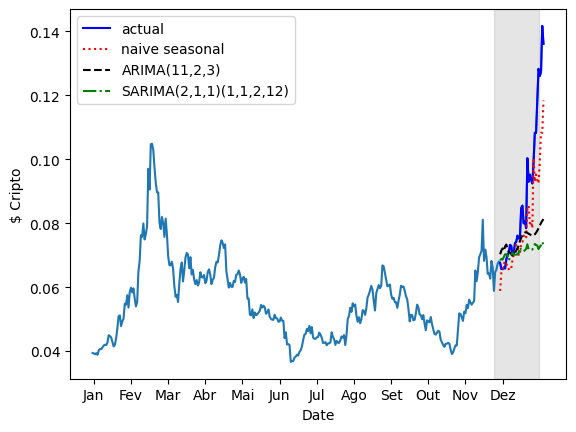

In [165]:
#Este código está gerando um gráfico que compara as previsões de diferentes modelos com os valores reais da criptomoeda
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Adjclose'])
ax.plot(test['Adjclose'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('$ Cripto')
plt.xticks(np.arange(1, 360, 30), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.axvspan(324, 360, color='#808080', alpha=0.2)

ax.legend(loc=2)


In [ ]:
#calcula o erro percentual absoluto médio (MAPE)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [167]:
#está calculando o erro percentual absoluto médio (MAPE)
#para três conjuntos de previsões: ‘naive_seasonal’, ‘ARIMA_pred’ e ‘SARIMA_pred’.
mape_naive_seasonal = mape(test['Adjclose'], test['naive_seasonal'])
mape_ARIMA = mape(test['Adjclose'], test['ARIMA_pred'])
mape_SARIMA = mape(test['Adjclose'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

9.419738522861126 14.363072908969322 16.697594508667557


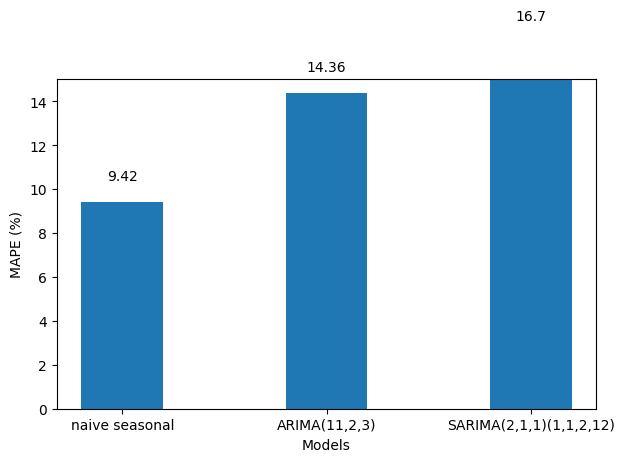

In [168]:
#Plota o gráfico com o resultado das previsões
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()